In [174]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd


In [ ]:
# CLEANING MVPS DATA

# load in mvp csv
mvps = pd.read_csv("mvps.csv")
# select necessary subsets/stats
mvps = mvps[["Player", "Year", "Pts Won", "Pts Max", "Share"]]
mvps.head()

In [ ]:
# CLEANING PLAYER DATA
players = pd.read_csv("players.csv")

del players["Unnamed: 0"]
del players["Rk"]


In [ ]:
# remove asterisk from player names for merging purposes
players["Player"] = players["Player"].str.replace("*","",regex=False)

In [ ]:
# only use player total stats (not stats under different teams) via grouping by year

def combine_teams(df):
    # only one row/team
    if df.shape[0] == 1:
        return df
    # replace TOT team with last team played for
    else:
        row = df[df["Tm"] == "TOT"]
        row["Tm"] = df.iloc[-1,:]["Tm"]
        return row

# group all players by year
players = players.groupby(["Player", "Year"]).apply(combine_teams, include_groups=False)

In [ ]:
# remove first 2 indexes (Player and Year) for redunancy
players.index = players.index = players.index.droplevel()
players.index = players.index = players.index.droplevel()

In [ ]:
# Merging mvps and players data sets
combined_data = players.merge(mvps, how="outer", on=["Player", "Year"])


In [ ]:
# Looking at only mvp candidates
# combined_data[combined_data["Pts Won"] > 0]

In [ ]:
# Replace NaN Values (votes = 0) 
combined_data[["Pts Won", "Pts Max", "Share"]] = combined_data[["Pts Won", "Pts Max", "Share"]].fillna(0)

In [ ]:
# CLEANING TEAM DATA
teams = pd.read_csv("teams.csv")

# remove division rows
teams = teams[~teams["W"].str.contains("Division")].copy()
# remove asterisks (teams that made playoffs)
teams["Team"] = teams["Team"].str.replace("*", "", regex=False)

In [ ]:
# create mapping csv file for team to abbreviations
nicknames_df = pd.read_csv("nicknames.txt") 
# storing this dataframe in a csv file 
nicknames_df.to_csv('nicknames.csv', index = None) 

In [ ]:
nicknames = {}
# read all lines in nicknames file

with open ("nicknames.csv") as f:
    lines = f.readlines();
    # skip header line
    for line in lines[1:]:
        abbreviation, name = line.replace("\n", "").split(",")
        nicknames[abbreviation] = name
        

In [ ]:
# mapping in combined data frame
combined_data["Team"] = combined_data["Tm"].map(nicknames)
combined_data.head(5)

In [ ]:
# Combine team data too
final_data = combined_data.merge(teams, how = "outer", on=["Team","Year"])
final_data


In [186]:
del final_data["Unnamed: 0"]

In [182]:
# modify data types to numeric
final_data = final_data.apply(pd.to_numeric, errors='ignore')
# games behind "-" should be 0
final_data["GB"] = pd.to_numeric(final_data["GB"].str.replace("—","0"))

In [190]:
# TRAINING DATA csv
final_data.to_csv("player_mvp_stats.csv")

<Axes: xlabel='Player'>

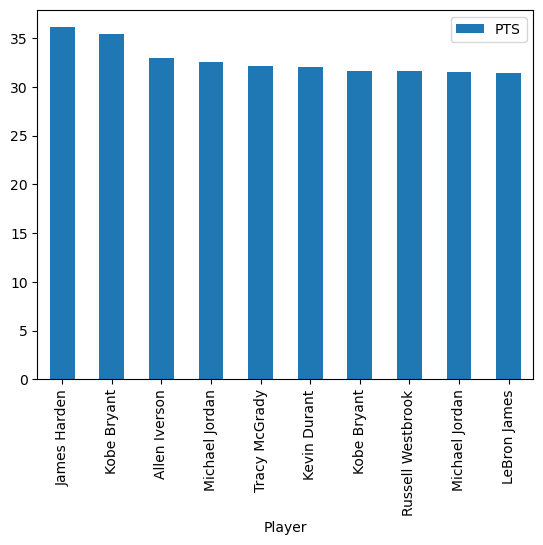

In [195]:
# some visualization
highest_scorers = final_data[final_data["G"] > 70].sort_values("PTS", ascending=False).head(10)
highest_scorers.plot.bar("Player", "PTS")

/var/folders/rq/ks9g0sx50871y2g219xxrfl80000gn/T/ipykernel_44833/1812570623.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  highest_scorers_year = final_data.groupby("Year").apply(lambda x: x.sort_values("PTS", ascending = False).head(1))


<Axes: xlabel='Player'>

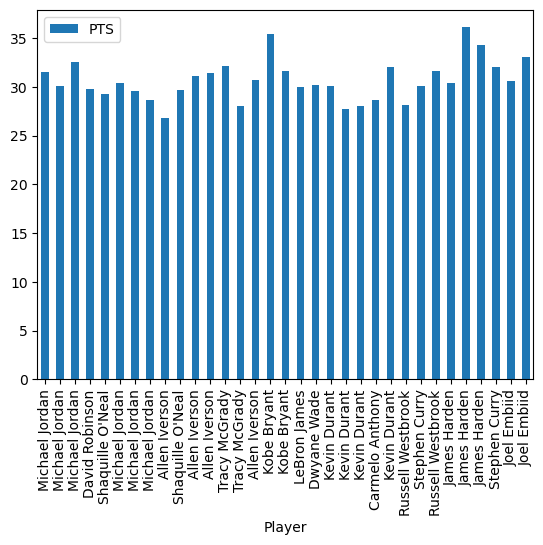

In [201]:
highest_scorers_year = final_data.groupby("Year").apply(lambda x: x.sort_values("PTS", ascending = False).head(1))
highest_scorers_year.plot.bar("Player", "PTS")

<Axes: >

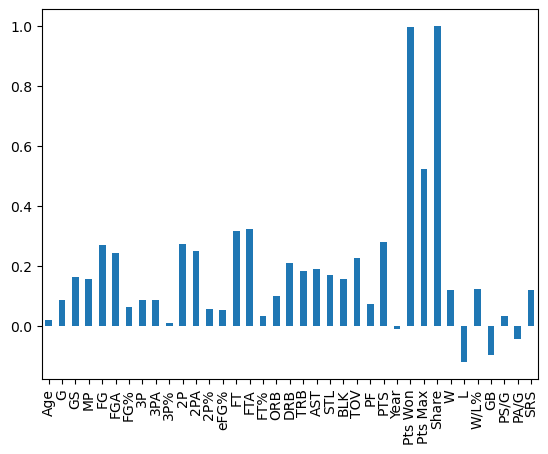

In [211]:
# some correlation
final_data.corr(numeric_only=True)["Share"].plot.bar()
